# Microcanonical Molecular Dynamics Simulation
Velocity Verlet Algorithm; created 07/09/24

#### References
- D. Frenkel and B. Smit, *Understanding Molecular Simulation*, Academic Press, 2002.

#### Work In Progress
- Documentation
- Calculate thermodynamic properties
- Radial distribution function
- Some optimisation

#### Goals:
- Implement a molecular dynamics simulation (velocity Verlet Algorithm) using the Lennard-Jones potential.
- Implement periodic boundary conditions.
- Extract thermodynamic properties: temperature, pressure, heat capacity (Ch 4.4 F&S).
- Simulate a bulk liquid and create a figure of the radial distribution function.

#### Additional goals:
- Testing with other algorithms (e.g. Leap Frog) and ensembles.
- Testing with molecules and including other force field terms.
- Testing with mixtures.
- Calculate statistical error (pg 98 F&S).
- Optimisation

## Libraries

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FormatStrFormatter
import sys
import os
import random

## Initial Parameters
All are in reduced units.

In [159]:
# Particle Parameters
m = 1 # Mass of particles
eps = 1 #epsilon
sig = 1 #sigma

# Initial Parameters
steps = 1000 # Time steps
N = 800 # Number of particles
L = 10 # Side of box
rc = 3*sig #Cut off radius for interactions
dt = 0.01 
T = 1 # Initial Temperature
density = m*N/L**3

# Constants
kb = 1

ecut = 4*eps*((sig/rc)**12 - (sig/rc)**6) # Potential at the cutoff; r = rc


## Functions
- length: Distance between two particles taking into account the minimum image convention.
- LJ: Potential energy of a particle as a sum of its pair-wise Lennard-Jones interactions.
- force: Components of force due to Lennard-Jones interactions.
- update: Updates the position, velocity, and acceleration of each particle after a single time step.
- energy: Returns the energy of the system as the sum of potential energy (LJ) and kinetic energy.

In [76]:
def length(position):
    
    Y = np.zeros((N, N))
    diff = np.zeros((N, N, 3))

    for i in range(N):
        diff[i] = position[i] - position #diff[i] is the difference in x/y/z coords of particle i to all other particles
        diff[i] = diff[i] - L*np.round(diff[i]/L, decimals=0) # difference between nearest image
        Y[i] = np.sum(diff[i]**2, axis=1) #Distance squared matrix

    return diff, Y


In [77]:
#Energy and force using Lennard-Jones

def energy(epsilon, sigma, position, velocity):

    LJ_array = np.zeros((N,3))
    coord, dist = length(position)
    dist[dist>rc**2] = 0 # Sets potential to those with distances creater than rc to be 0 (truncate)

    with np.errstate(divide='ignore', invalid='ignore'):
        a = (sigma/dist)**6
        b = (sigma/dist)**3
        LJ_array = 4*epsilon*(a - b) - ecut # Shifts potential
        LJ_array[LJ_array == np.inf] = 0
        LJ_array = np.nan_to_num(LJ_array)

    pot = np.sum(LJ_array)
    kin = 0.5*m*np.sum(velocity**2)
    return pot, kin


def force(epsilon, sigma, position):

    force_array = np.zeros((N,N,3))
    coord, dist = length(position)
    dist[dist>rc**2] = 0

    dist = np.repeat(dist[:, :, np.newaxis], 3, axis=2)

    with np.errstate(divide='ignore', invalid='ignore'):
        a = (sigma/dist)**6
        b = (sigma/dist)**3
        force_array = ((48*epsilon*coord)/dist)*(a - 0.5*b)
        force_array[force_array == np.inf] = 0
        force_array = np.nan_to_num(force_array)

    return np.sum(force_array, axis=1)


In [78]:
def update(position, velocity, acceleration, delta):
    """
    Returns the updated positions, velocities, and accelerations of the particles after one time step.
    
    Parameters
    ----------
    position: ndarray of floats, N x 3
        x, y, z coordinates of each particle.

    velocity: ndarray of floats, N x 3
        x, y, z component of velocity of each particle.

    acceleration: ndarray of floats, N x 3
        x, y, z coordinates of each particle.
    
    Returns
    -------
    ndarray of 3 ndarrys of floats
        Updated arrays of position, velocity, and acceleration of each particle.
    """
    new_r = (position + delta*velocity + 0.5*acceleration*delta**2) % L
    new_a = force(eps, sig, new_r)/m
    new_v = velocity + 0.5*delta*(acceleration + new_a)
    return new_r, new_v, new_a

In [157]:
r_range = np.linspace(0, L/2,num=100)

def g(position):
    coord, dist = length(position)
    dist = np.sqrt(dist)

    counts,edges = np.histogram(dist[dist!=0], bins=r_range)
    counts = counts/2 # Prevent double counting
    
    ideal = np.empty((len(edges)-1))
    for i in range(len(edges)-1):
        ideal[i] = (4/3)*np.pi*density*(edges[i+1]**3 - edges[i]**3) # Number of particles if ideal

    return counts/ideal

#### Data Files
Code below creates a directory named "data" and contains function gen_file which generates .xyz data files, for use for visualisation.

I used OVITO to visualise my simulation runs.

In [133]:
outdir="data"
try: #make directory if it does not exist
    os.mkdir(outdir)
except:
    pass

def gen_file(r,t):
    fname=outdir+"/t"+str(t+1)+".xyz"
    f=open(fname,"w")
    f.write(str(N) + "\n") # number of atoms
    f.write('Lattice="'+ str(L) +" 0.0 0.0 0.0 " + str(L) +" 0.0 0.0 0.0 " + str(L) + '" '
            + "Properties="+"pos:R:3" + "\n") # Periodic bc not specified so are assumed
    for i in range(len(r)):
        f.write(str(r[i][0])+" "+str(r[i][1])+" "+str(r[i][2])+"\n")
    f.close

## Initialisation

In [160]:
#Initial conditions


r = set() # Allows each particle to be 1 apart whilst preventing duplicates
while len(r) < N:
    p = (random.randint(0, L-1), random.randint(0, L-1), random.randint(0, L-1)) # Using np.random.randit takes much much longer - for 100 particles, it still hasn't finished after 2+ mins whilst here it takes 0.1s
    if p not in r:
        r.add(p)

r = np.array(list(r))
v = np.random.rand(N, 3) - 0.5 #Random velocities between -0.5 and 0.5

a = force(eps, sig, r)/m # Initial acceleration

r0 = r

In [161]:
# Scaling velocities to initial temperature

v_com = np.sum(v,axis=0)/N # velocity centre of mass
v = v - v_com

U, KE = energy(eps, sig, r, v)

temp = 2*KE/(3*N*kb) # Instantaneous T of system; F&S Eq 4.2.2; Factor of 2 is due to KE being 0.5 mv^2
sf = np.sqrt(T/temp)

v = sf*v # Sets centre of mass to be 0, and scales v to be that of set temp.

## Running the Simulation

Progress: 99.90%

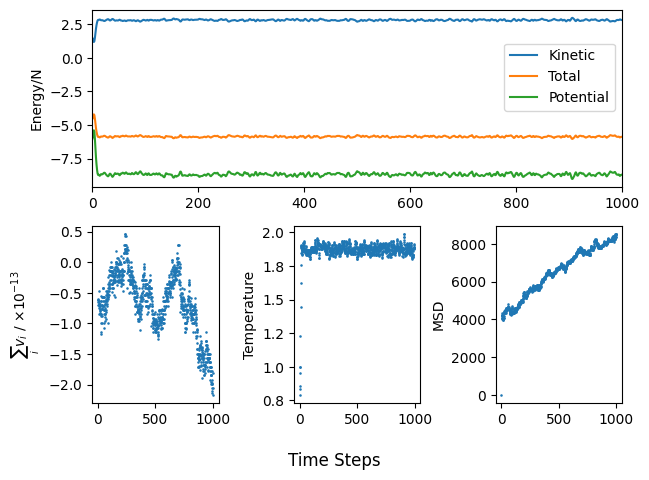

In [162]:
fig, axes = plt.subplot_mosaic("DDD;ABC")

run = 1 # If wanting to edit graphs/mess around with data without doing another simulation run

if run==1:
    sumv = np.empty((steps)) # Total velocity
    kinetic = np.empty((steps)) # Kinetic energy
    potential = np.empty((steps)) # Potential energy
    MSD = np.empty((steps)) # Average mean squared displacement over all particles
    radial_dist = np.empty((steps))

    for i in range(steps):
        gen_file(r,int(i/20))
        sumv[i] = np.sum(v)
        potential[i], kinetic[i] = energy(eps, sig, r, v)
        MSD[i] = np.mean(np.sum((r-r0)**2, axis=0))
        r, v, a = update(r,v,a,dt)
        sys.stdout.write('\r')
        sys.stdout.write("Progress: {:.2%}".format(i/steps))
        sys.stdout.flush()

E = kinetic + potential
inst_temp = 2*kinetic/(3*N*kb) #Instantaneous temperature of system

axes["A"].scatter(np.arange(steps), sumv,s=0.7)
axes["A"].yaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
axes["A"].yaxis.get_offset_text().set_visible(False)
axes["A"].set_xticks([0, steps/2, steps])

axes["B"].scatter(np.arange(steps), inst_temp, label="Temp", s=0.7)
axes["B"].set_ylabel("Temperature")
axes["B"].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axes["B"].set_xticks([0, steps/2, steps])

axes["C"].scatter(np.arange(steps), MSD, label="MSD", s=0.7)
axes["C"].set_ylabel("MSD")
axes["C"].set_xticks([0, steps/2, steps])

axes["D"].plot(np.arange(steps), kinetic/N, label="Kinetic")
axes["D"].plot(np.arange(steps), E/N, label="Total")
axes["D"].plot(np.arange(steps), potential/N, label = "Potential")

axes["D"].set_ylabel("Energy/N")
axes["D"].legend(loc="center right", bbox_to_anchor=(1,0.62))
axes["D"].set_xlim(0, steps)

fig.supxlabel("Time Steps")

plt.tight_layout(w_pad=0)
offset = axes["A"].yaxis.get_major_formatter().get_offset() # Empty string if called before tight_layout
axes["A"].set_ylabel("$ \sum_{i} v_{i} $" + " / " + offset)

plt.show()


In [163]:
print("Temperature: {:.3f} +/- {:.4f}". format(np.mean(inst_temp), np.std(inst_temp)/np.sqrt(N)))
print("Kinetic Energy: {:.3f} +/- {:.2g}".format(np.mean(kinetic), np.std(kinetic)/np.sqrt(N)))
print("Potential Energy: {:.3f} +/- {:.2g}".format(np.mean(potential), np.std(potential)/np.sqrt(N)))
print("Total Energy: {:.3f} +/- {:.2g}".format(np.mean(E), np.std(E)/np.sqrt(N)))

Temperature: 1.870 +/- 0.0030
Kinetic Energy: 2243.870 +/- 3.6
Potential Energy: -6929.339 +/- 7.3
Total Energy: -4685.469 +/- 3.7


[[0.         5.79114378 2.40591047 ... 7.0818075  5.47443461 4.951993  ]
 [5.79114378 0.         6.08904761 ... 5.26195528 4.36288936 6.18406826]
 [2.40591047 6.08904761 0.         ... 5.16459552 3.2895774  6.59689631]
 ...
 [7.0818075  5.26195528 5.16459552 ... 0.         2.50916434 3.67744596]
 [5.47443461 4.36288936 3.2895774  ... 2.50916434 0.         5.01404207]
 [4.951993   6.18406826 6.59689631 ... 3.67744596 5.01404207 0.        ]]


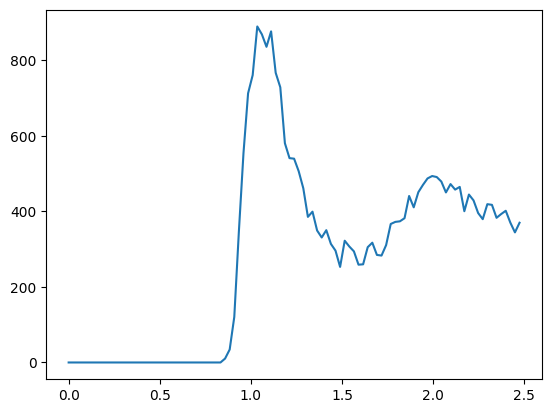

In [164]:
plt.plot(r_range[:-1],g(r))
#General shape looks right but y axis way off